**PIA-Entrenamiento de una Red Convolucional.**"CATS-AND-DOGS"

---

***Integrantes***

Abraham Emanuel Cazares Avila

Diego Armando Trejo Piña

Karla Ivette Zamudio Montoro

**Objetivo**

Entrenar una red neuronal convolucional (CNN) en un conjunto de imagenes de libre elección.

**Instrucciones**

Para el proyecto final,se entrenará una Red Nueronal Convolucional (CNN)en un cuaderno de colab con un conjunto de datos que el equipo elija desde la página oficial de kaggle.

**Instalamos la libreria kaggle** 

---



In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


***Se crea un directorio para kaggle en la ubicación de la instancia temporal en la unidad Colab.***

---


Descarga la clave API kaggle (archivo .json).

In [3]:
! mkdir ~/.kaggle

Copiamos las credenciales de la API de kaggle a la ubicación temporal.

In [4]:
! cp kaggle.json ~/.kaggle/

***Descargue y prepare el conjunto de datos***

---
El conjunto de datos cad-and-dog contiene 10 032 imágenes en color con 2 clases.El conjunto de datos se divide en 8007 imágenes de entrenamiento y 2025 imágenes de prueba. Las clases son mutuamente excluyentes y no hay superposición entre ellas.


In [5]:
! kaggle datasets download tongpython/cat-and-dog

 99% 215M/218M [00:05<00:00, 56.9MB/s]
100% 218M/218M [00:05<00:00, 45.2MB/s]


***Descomprimir, en caso de que el archivo descargado esté comprimido.***

In [6]:
! unzip cat-and-dog.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jp

***Instalar la ultima actualización de tensorflow***

In [ ]:
!pip install --upgrade tensorflow

***IMPORTAR LIBRERIAS***

---



In [18]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # carga y preprocesa automáticamente las imágenes, incluyendo la redimensión de las imágenes al tamaño especificado.
import matplotlib.pyplot as plt

Se definen algunas variables para ajustar la configuración del procesamiento de datos y entrenamiento del modelo

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #permite que TensorFlow ajuste automáticamente la cantidad de recursos para el procesamiento de datos
BATCH_SIZE = 16             #establece el tamaño de lote para el entrenamiento y la validación
IMAGE_SIZE = [80, 100]      #indica el tamaño al que se redimensionarán las imágenes.
EPOCHS = 10                 #establece el número de épocas de entrenamiento.

***Cargar el conjunto de datos de entrenamiento desde el directorio***

---



In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/training_set/training_set', #Se carga desde el directorio el conjunto de datos de entrenamiento
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/test_set/test_set', #Se carga desde el directorio el conjunto de datos de validación 
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 2023 files belonging to 2 classes.
Using 404 files for validation.


***Se definen las clases de los datos de entrenamiento***

---



En este caso debido al mismo nombre del set de datos, contamos con 2 clases: 'cat' and 'dog'

In [23]:
class_names = ['cat', 'dog']
NUM_CLASSES = len(class_names)

***Normalización de los valores***

---



In [24]:
def preprocess_input(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # Normalización de los valores de píxeles
    return image, label

***Verifica los datos***

---


Para verificar que el conjunto de datos se vea correcto, tracemos las primeras 20 imágenes del conjunto de entrenamiento y mostremos el nombre de la clase encima de cada imagen:

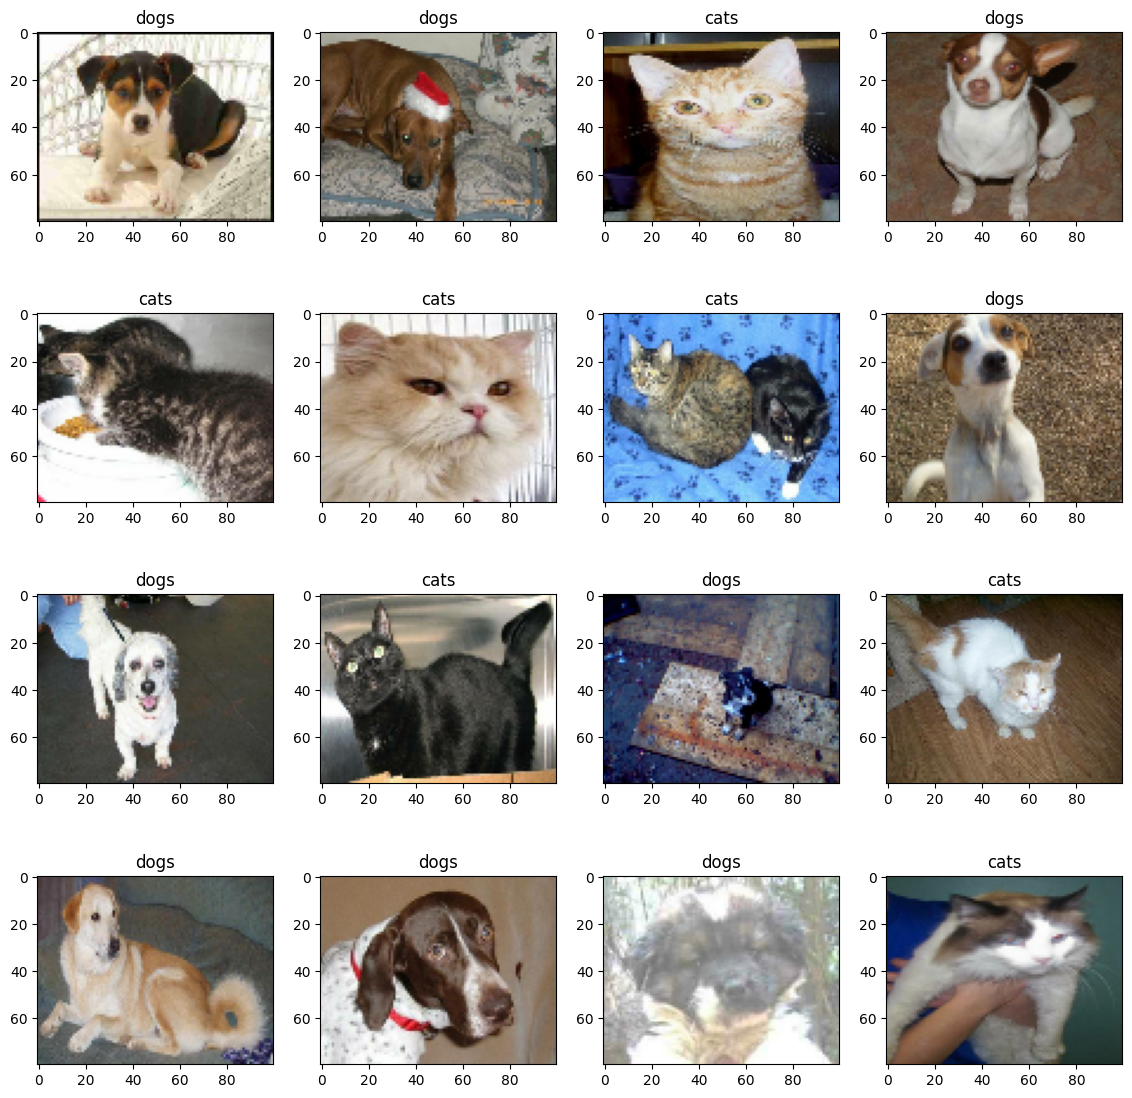

In [25]:
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("on")

In [26]:
train_ds = train_ds.map(preprocess_input, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_input, num_parallel_calls=AUTOTUNE)

***Crear la base convolucional***


---


Las 6 líneas de código a continuación definen la base convolucional utilizando un patrón común: una pila de capas Conv2D y MaxPooling2D .

Como entrada, una CNN toma tensores de forma (altura_imagen, ancho_imagen, canales_color), ignorando el tamaño del lote. Si eres nuevo en estas dimensiones, color_channels se refiere a (R,G,B). 

In [27]:
#La red consta de varias capas convolucionales y capas de agrupación, seguidas de una capa de aplanamiento
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

***Compilar y entrenar al modelo***

---



In [28]:
# Compilación del modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Se entrena el modelo utilizando el método fit, donde se pasa el conjunto de datos de entrenamiento train_ds y el conjunto de datos de validación val_ds. También se especifica el número de épocas EPOCHS para el entrenamiento

In [30]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

401/401 [==============================] - 138s 339ms/step - loss: 0.6861 - accuracy: 0.5523 - val_loss: 0.6683 - val_accuracy: 0.5941
Epoch 2/10
401/401 [==============================] - 131s 326ms/step - loss: 0.6368 - accuracy: 0.6362 - val_loss: 0.6553 - val_accuracy: 0.6386
Epoch 3/10
401/401 [==============================] - 136s 339ms/step - loss: 0.5904 - accuracy: 0.6879 - val_loss: 0.5931 - val_accuracy: 0.6931
Epoch 4/10
401/401 [==============================] - 135s 336ms/step - loss: 0.5295 - accuracy: 0.7336 - val_loss: 0.5795 - val_accuracy: 0.7129
Epoch 5/10
401/401 [==============================] - 133s 329ms/step - loss: 0.4748 - accuracy: 0.7731 - val_loss: 0.5904 - val_accuracy: 0.7178
Epoch 6/10
401/401 [==============================] - 135s 336ms/step - loss: 0.4273 - accuracy: 0.7997 - val_loss: 0.5498 - val_accuracy: 0.7550
Epoch 7/10
401/401 [==============================] - 142s 355ms/step - loss: 0.3587 - accuracy: 0.8376 - val_loss: 0.6196 - val_accura

Después de entrenar el modelo, se evalúa su desempeño utilizando el conjunto de datos de validación (val_ds). Se calcula la pérdida y la precisión del modelo y se imprimen en la consola.

In [31]:
loss, accuracy = model.evaluate(val_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

26/26 [==============================] - 2s 82ms/step - loss: 0.9241 - accuracy: 0.7450
Loss: 0.9240943193435669
Accuracy: 0.7450494766235352


***PREDICCIONES***

---



1/1 [==============================] - 0s 93ms/step


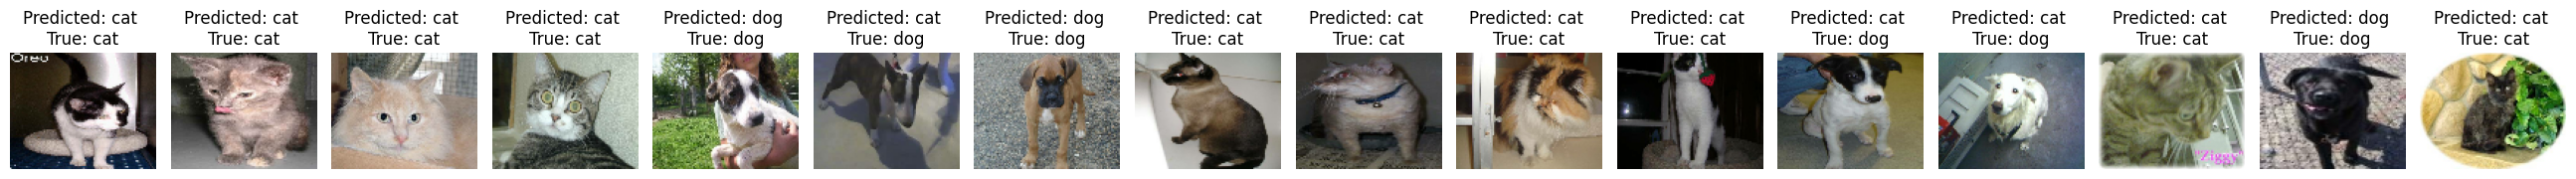

In [53]:
sample_images = []
sample_labels = []

for images, labels in val_ds.take(1):
    sample_images = images
    sample_labels = labels

# Realizar las predicciones
predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Define una función para visualizar las imágenes y sus etiquetas
def mostrar_predictions(images, predictions):
    fig, axs = plt.subplots(1, len(images), figsize=(26, 26)) 
    for i, ax in enumerate(axs):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(f"Predicted: {class_names[int(predicted_labels[i])]} \nTrue: {class_names[int(sample_labels[i])]}")
        ax.margins(8.5)  
    plt.tight_layout()  
    plt.show()

# Llama a la función para mostrar las predicciones
mostrar_predictions(sample_images, predictions)


# Obtener las etiquetas predichas
predicted_labels = np.argmax(predictions, axis=1)


***EVALUACION DEL MODELO***

---



Se crea una gráfica para visualizar la precisión del modelo a lo largo de las épocas de entrenamiento. 


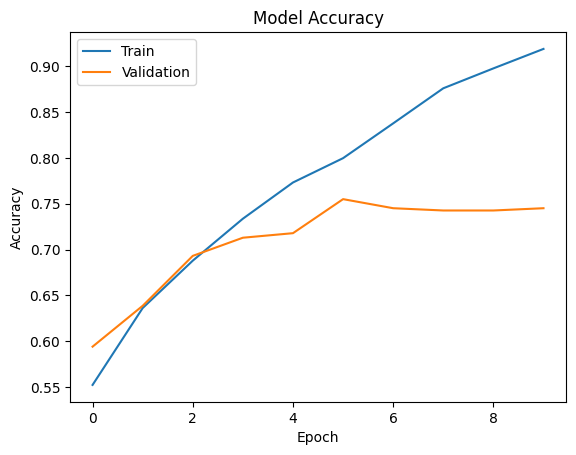

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Finalmente, se imprime la precisión del modelo en la última época evaluada.

In [55]:
print(accuracy)

0.7450494766235352
